# FinBERT Predictions on All Labeled Tweets

This notebook uses the fine-tuned FinBERT model to predict sentiment on the all_labeled_tweets.csv dataset and saves the results to a new file.

## Process Overview
1. Load the fine-tuned FinBERT model
2. Load the all_labeled_tweets.csv dataset
3. Predict sentiment using the FinBERT model
4. Save the predictions to a new CSV file

In [6]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [7]:
# Check for MPS availability
mps_available = torch.backends.mps.is_available()
gpu_available = torch.cuda.is_available()
device = torch.device("mps" if mps_available else "cuda" if gpu_available else "cpu")
print(f"MPS available: {mps_available}")
print(f"GPU available: {gpu_available}")
print(f"Using device: {device}")


MPS available: True
GPU available: False
Using device: mps


## Load Model and Data

In [8]:
# Initialize tokenizer
print("Loading FinBERT tokenizer...")
finbert_tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

# Load FinBERT model with original number of labels (3)
finbert_model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
# Resize the classifier to 5 labels
hidden_size = finbert_model.config.hidden_size
finbert_model.config.num_labels = 5
finbert_model.num_labels = 5
# Replace the classifier with a new one that has 5 outputs
finbert_model.classifier = torch.nn.Linear(hidden_size, 5)

# Load safetensors model file using safetensors library
from safetensors.torch import load_file
state_dict = load_file('../models/finbert/model.safetensors')
finbert_model.load_state_dict(state_dict)
finbert_model = finbert_model.to(device)
print(f"FinBERT model device: {next(finbert_model.parameters()).device}")
finbert_model.eval()

# Map numeric predictions back to sentiment labels
sentiment_mapping = {
    'STRONGLY_POSITIVE': 0,
    'POSITIVE': 1,
    'NEUTRAL': 2,
    'NEGATIVE': 3,
    'STRONGLY_NEGATIVE': 4
}

# Load all labeled tweets
print("Loading all_labeled_tweets.csv...")
tweets_df = pd.read_csv('../data/all_labeled_tweets.csv')
print(f"Loaded {len(tweets_df)} tweets")

Loading FinBERT tokenizer...
FinBERT model device: mps:0
Loading all_labeled_tweets.csv...
Loaded 28172 tweets


## Prediction Function

In [9]:
def predict_sentiment(model, tokenizer, texts, batch_size=32):
    predictions = []
    prediction_scores = []
    inference_times = []
    
    # Process in batches
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        
        # Move inputs to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            # Get the predicted class
            preds = torch.argmax(logits, dim=1)
            # Get probabilities using softmax
            probs = torch.nn.functional.softmax(logits, dim=1)
        inference_time = time.time() - start_time
        
        # Move predictions back to CPU for NumPy conversion
        predictions.extend(preds.cpu().numpy())
        prediction_scores.extend(probs.cpu().numpy())
        inference_times.extend([inference_time / len(batch_texts)] * len(batch_texts))
    
    return predictions, prediction_scores, np.mean(inference_times)

## Run Predictions

In [11]:
# Get text column name - could be 'description' or 'text' depending on the dataset
text_column = 'description' if 'description' in tweets_df.columns else 'text'

print(f"Making predictions on column: {text_column}")
predictions, prediction_scores, avg_inference_time = predict_sentiment(
    finbert_model, 
    finbert_tokenizer, 
    tweets_df[text_column].tolist()  # Convert to list for consistency with model comparison notebook
)

print(f"Average inference time per tweet: {avg_inference_time*1000:.2f} ms")

# Map predictions to sentiment labels
# Create reverse mapping (from numeric values to sentiment labels)
reverse_sentiment_mapping = {v: k for k, v in sentiment_mapping.items()}
predicted_sentiments = [reverse_sentiment_mapping[int(pred)] for pred in predictions]

# Add predictions and confidence scores to the dataframe
tweets_df['finbert_predicted_sentiment'] = predicted_sentiments
tweets_df['finbert_predicted_class'] = predictions

# Add confidence scores for each class
for sentiment, i in sentiment_mapping.items():
    tweets_df[f'finbert_score_{sentiment}'] = [scores[i] for scores in prediction_scores]

Making predictions on column: description


100%|██████████| 881/881 [03:10<00:00,  4.63it/s]

Average inference time per tweet: 0.60 ms


## Analyze Predictions

Prediction counts by sentiment:
finbert_predicted_sentiment
NEUTRAL              20731
POSITIVE              4010
NEGATIVE              2555
STRONGLY_NEGATIVE      523
STRONGLY_POSITIVE      353
Name: count, dtype: int64

Percentage distribution:
finbert_predicted_sentiment
NEUTRAL              73.587250
POSITIVE             14.233991
NEGATIVE              9.069289
STRONGLY_NEGATIVE     1.856453
STRONGLY_POSITIVE     1.253017
Name: count, dtype: float64


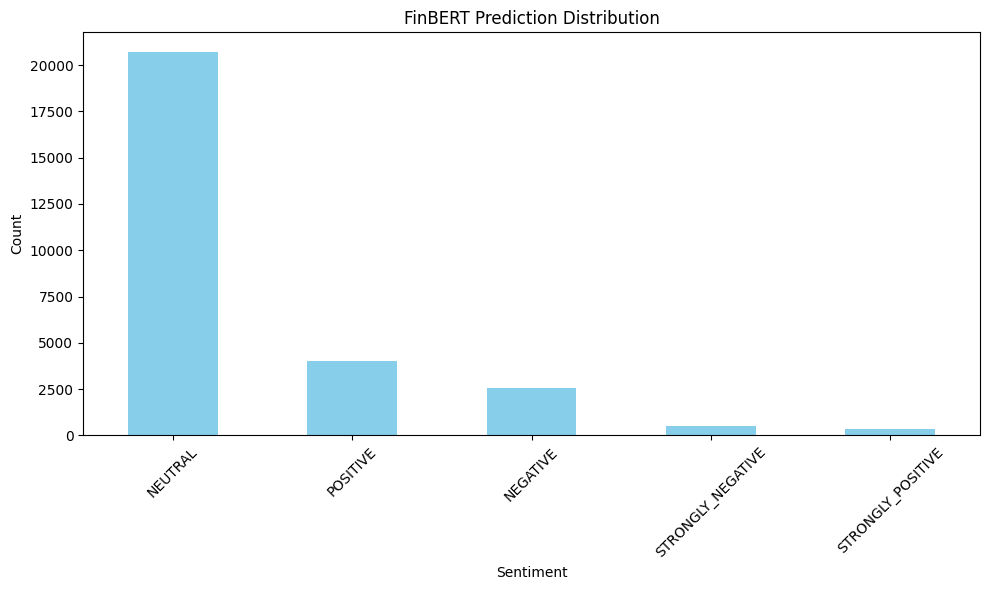

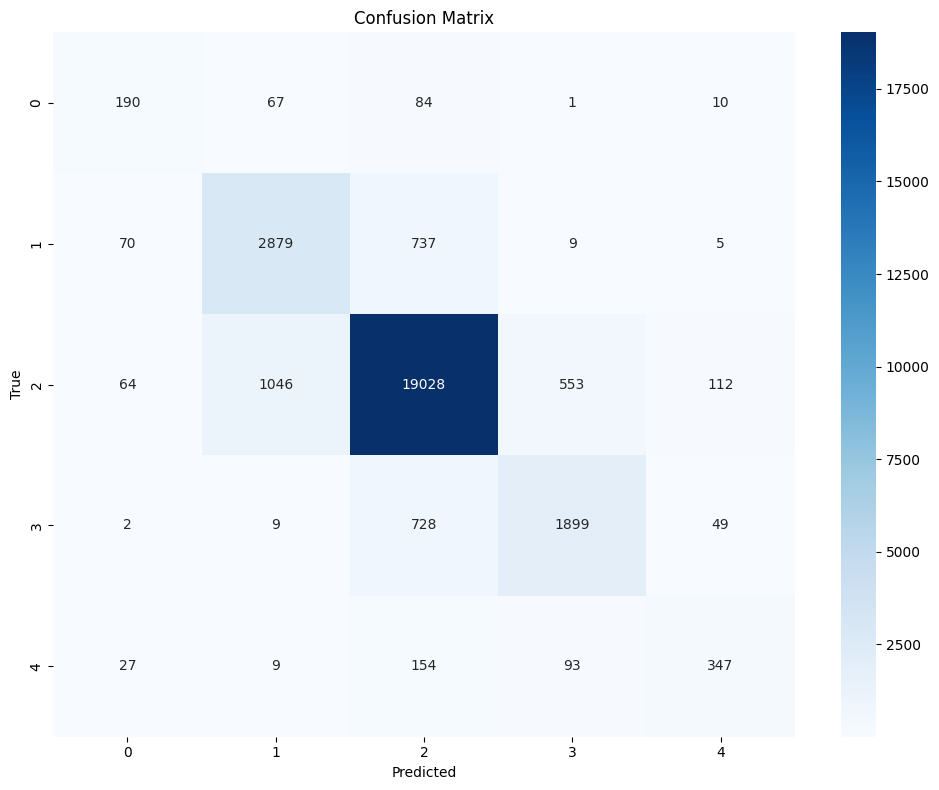


Model Performance Metrics:
Accuracy: 0.8641
Precision: 0.8645
Recall: 0.8641
F1 Score: 0.8640


In [12]:
# Count predictions by sentiment
sentiment_counts = tweets_df['finbert_predicted_sentiment'].value_counts()
print("Prediction counts by sentiment:")
print(sentiment_counts)

# Calculate percentage distribution
sentiment_percentages = sentiment_counts / len(tweets_df) * 100
print("\nPercentage distribution:")
print(sentiment_percentages)

# Plot distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('FinBERT Prediction Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# If the original dataset has sentiment labels, compare with predictions
if 'sentiment' in tweets_df.columns:
    # Create a confusion matrix
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    # Map original sentiment labels to numeric values
    orig_sentiment_mapping = {
        'STRONGLY_NEGATIVE': 0,
        'NEGATIVE': 1,
        'NEUTRAL': 2,
        'POSITIVE': 3,
        'STRONGLY_POSITIVE': 4
    }
    
    # Convert original sentiment labels to numeric
    original_labels = tweets_df['sentiment'].map(lambda x: orig_sentiment_mapping.get(x, 2)).tolist()  # Convert to list for consistency
    
    # Create confusion matrix
    cm = confusion_matrix(original_labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(sentiment_mapping.values()),
                yticklabels=list(sentiment_mapping.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    
    accuracy = accuracy_score(original_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(original_labels, predictions, average='weighted')
    
    print(f"\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

## Save Predictions

In [13]:
# Create timestamp for the output file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_file = f"../data/finbert_predictions_{timestamp}.csv"

# Save the predictions to CSV
print(f"Saving predictions to {output_file}")
tweets_df.to_csv(output_file, index=False)

print("Prediction process completed.")

Saving predictions to ../data/finbert_predictions_20250401_125126.csv
Prediction process completed.


## Sample Predictions

In [14]:
# Display a sample of predictions
print("Sample of predictions:")
sample_df = tweets_df.sample(10, random_state=42)
sample_columns = [text_column, 'finbert_predicted_sentiment']

# Add original sentiment if available
if 'sentiment' in tweets_df.columns:
    sample_columns.insert(1, 'sentiment')

sample_df[sample_columns]

Sample of predictions:


,description,sentiment,finbert_predicted_sentiment
5908,This person caught it also \n\n> [@KrisPatel99...,NEGATIVE,NEUTRAL
905,$CLSK is the strongest of the group and breaki...,NEUTRAL,NEGATIVE
9212,$DUOL\n\nStill holding onto this. Took some pr...,NEUTRAL,NEUTRAL
7132,Oh yeah…. $COIN,NEUTRAL,NEUTRAL
8184,$SPY Weekly. Broke out from the pennant patter...,NEUTRAL,NEUTRAL
5365,$OXY seems like warren is about to get the las...,NEUTRAL,POSITIVE
19311,$SLNA damn it’s slowly happening \n\n> [@MrZac...,STRONGLY_NEGATIVE,NEUTRAL
16672,$ATVI juicy gap to the downside. I'm not good ...,NEGATIVE,POSITIVE
11776,"Ok team, we knew today was going to be rough w...",NEUTRAL,NEUTRAL
7585,$GME 45min ...,NEUTRAL,NEUTRAL
